In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [3]:
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
base = Path('/content/drive/My Drive')
sys.path.append(str(base))

In [0]:
zip_path = base/'ddd.zip'
!cp "{zip_path}" .
!unzip -q ddd.zip
!rm ddd.zip

In [6]:
cd 'Distracted Driver Detection'

/content/Distracted Driver Detection


In [7]:
import pandas as pd
driver_details = pd.read_csv('driver_imgs_list.csv', na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [0]:
import os
import cv2

train_image = []
image_label = []


for i in range(10):
    images = os.listdir("images/train/c"+str(i))
    for j in range(len(images)):
        image_name = "images/train/c"+str(i)+"/"+images[j]
        if (".DS_Store" not in image_name):
          img = cv2.imread(image_name)
          #mg = color.rgb2gray(img)
          img = img[50:,120:-50]
          img = cv2.resize(img,(224,224))
          label = i
          driver = driver_details[driver_details['img'] == images[j]]['subject'].values[0]
          train_image.append([img,label,driver])
          image_label.append(i)

In [0]:
import random
random.shuffle(train_image)

** Splitting the train and test**

In [0]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [12]:
X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [13]:
## Converting images to nparray. Encoding the Y
import numpy as np
from tensorflow.keras.utils import to_categorical

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18732, 224, 224, 3)


In [14]:
## Defining the input
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')

#Get back the convolutional part of a vgg16 network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape= (224,224,3))
model_vgg16_conv.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________________

In [15]:
#Use the generated model 
from keras.models import Model
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
x_output = Dense(10, activation='softmax', name='predictions')(x)
vgg16_pretrained = Model(inputs = vgg16_input , outputs = x_output)
vgg16_pretrained.summary()

# Compile CNN model
sdg = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sdg,metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________




### Running VGG with Image Augmentation


In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
293/292 [==============================] - 204s 698ms/step - loss: 2.4664 - acc: 0.1170 - val_loss: 2.3070 - val_acc: 0.0910

Epoch 00001: val_loss improved from inf to 2.30696, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 2/25
293/292 [==============================] - 191s 652ms/step - loss: 2.2423 - acc: 0.1600 - val_loss: 2.2380 - val_acc: 0.1801

Epoch 00002: val_loss improved from 2.30696 to 2.23804, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 3/25
293/292 [==============================] - 191s 654ms/step - loss: 2.1692 - acc: 0.1891 - val_loss: 2.1325 - val_acc: 0.1750

Epoch 00003: val_loss improved from 2.23804 to 2.13253, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 4/25
293/292 [==============================] - 194s 660ms/step - loss: 1.9993 - acc: 0.2532 - val_loss: 1.8166 - val_acc: 0.2895

Epoch 00004: val_loss improved from 2.13253 to 1

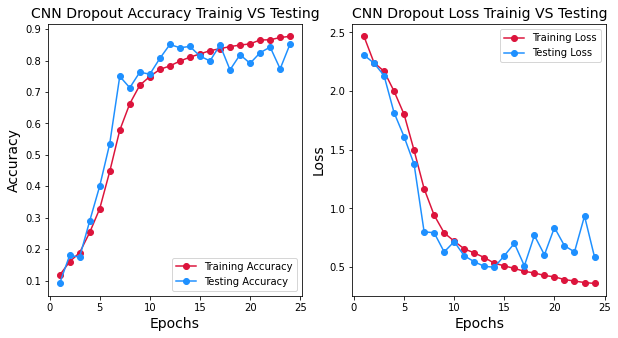

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['acc']) + 1), vgg16_pretrained.history.history['acc'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_acc']) + 1), vgg16_pretrained.history.history['val_acc'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')